In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

import matplotlib.pyplot as plt
import seaborn as sns

from pandas import DataFrame
from pandas import Series

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# read in data
local_file="DataPrep/title.ratings.genresS.actorsG.csv"
source=local_file
df = pd.read_csv(source, sep='\t')
df.drop(df.columns[0], inplace=True, axis=1)

df["runtimeMinutes"]=df.runtimeMinutes.apply(int)
df["numVotes"]=df.numVotes.apply(int)

In [13]:
# df.head()
# df.dtypes
# list(df)

,tconst,principalCast,genre,titleType,primaryTitle,runtimeMinutes,averageRating,numVotes
0,tt0000009,"nm0085156,nm0183823,nm0063086,nm1309758",Romance,movie,Miss Jerry,45,5.4,58
1,tt0000147,"nm0280615,nm4082222,nm2256592,nm0103755,nm0714...",Documentary,movie,The Corbett-Fitzsimmons Fight,20,5.2,236
2,tt0000147,"nm0280615,nm4082222,nm2256592,nm0103755,nm0714...",News,movie,The Corbett-Fitzsimmons Fight,20,5.2,236
3,tt0000147,"nm0280615,nm4082222,nm2256592,nm0103755,nm0714...",Sport,movie,The Corbett-Fitzsimmons Fight,20,5.2,236
4,tt0000574,"nm2421834,nm0170118,nm0846911,nm0846894,nm0425...",Biography,movie,The Story of the Kelly Gang,70,6.4,413


In [1]:
# df.genre.unique()

In [4]:
def modStats(model):
    modParams=model.params
    modAOVTable = sm.stats.anova_lm(model, typ=2)
    modSummary=model.summary()
    return(modParams, modAOVTable, modSummary)

In [5]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

#### ANOVA: ratings ~ genre

In [6]:
mod = smf.ols(formula='averageRating ~ genre', data=df).fit()
modParams, modAOVTable, modSummary=modStats(mod)
eta_squared(modAOVTable)
omega_squared(modAOVTable)
print(modAOVTable)

                 sum_sq        df            F  PR(>F)    eta_sq  omega_sq
genre      68847.056066      27.0  1756.723854     0.0  0.134934  0.134857
Residual  441380.466435  304085.0          NaN     NaN       NaN       NaN


#### Determine which genre ratings differ significantly

In [25]:
genre_list = ['Action','Adult', 'Adventure', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Horror','Romance','Thriller']
test = multi.MultiComparison(df['averageRating'], df['genre'])
res = test.tukeyhsd()
df2 = pd.DataFrame(data=res._results_table.data[1:], columns=res._results_table.data[0])

df2 = df2[df2.group1.isin(genre_list)]
df2 = df2[df2.group2.isin(genre_list)]

#d2.sort_values(['meandiff'], ascending=0)
print("5 Greatest + Mean Differences Between Genres\n")
print(df2.nlargest(5, 'meandiff'),'\n')
print("5 Greatest - Mean Differences Between Genres\n")
print(df2.nsmallest(5, 'meandiff'))

5 Greatest + Mean Differences Between Genres

        group1       group2  meandiff   lower   upper  reject
6       Action  Documentary    1.5144  1.4701  1.5587    True
32       Adult  Documentary    1.5020  1.4121  1.5919    True
126     Comedy  Documentary    1.2529  1.2175  1.2883    True
57   Adventure  Documentary    1.2378  1.1867  1.2890    True
147      Crime  Documentary    1.1534  1.1078  1.1989    True 

5 Greatest - Mean Differences Between Genres

          group1    group2  meandiff   lower   upper  reject
174  Documentary    Horror   -2.1627 -2.2122 -2.1133    True
185  Documentary  Thriller   -1.5918 -1.6386 -1.5450    True
193        Drama    Horror   -1.2604 -1.3036 -1.2172    True
211       Family    Horror   -1.1870 -1.2540 -1.1201    True
180  Documentary   Romance   -1.0344 -1.0771 -0.9917    True


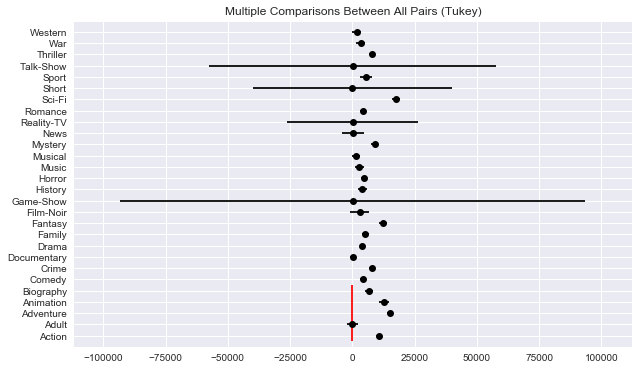

In [7]:
# second validation method 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df.numVotes,     # Data
                          groups=df.genre,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")
plt.show()

#### Visualize genre rating differences

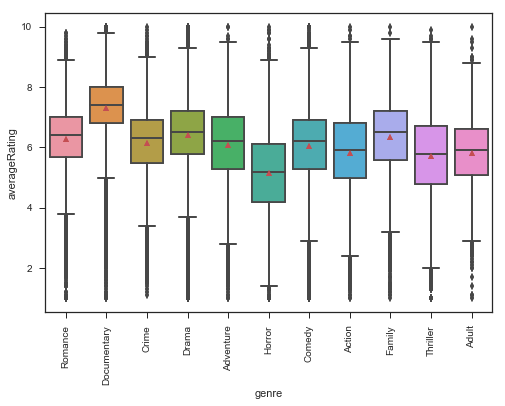

In [13]:
sns.set(style="ticks")
df3 = df[df.genre.isin(genre_list)]

sns.boxplot(x=df3['genre'], y=df3['averageRating'], showmeans=True)
plt.xticks(rotation=90)
plt.show()
# plt.savefig('genre_box.png')

#### ANOVA: ratings ~ genre and # of votes

In [16]:
mod2 = smf.ols('averageRating ~ genre + numVotes + genre:numVotes', data=df).fit()
mod2Params, mod2AOVTable, mod2Summary=modStats(mod2)
eta_squared(mod2AOVTable)
omega_squared(mod2AOVTable)
print(mod2AOVTable)

                       sum_sq        df            F        PR(>F)    eta_sq  \
genre            70786.963211      27.0  1834.051316  0.000000e+00  0.138211   
numVotes          6215.538080       1.0  4348.111750  0.000000e+00  0.012136   
genre:numVotes     521.577315      27.0    13.513782  7.441319e-61  0.001018   
Residual        434643.351042  304057.0          NaN           NaN       NaN   

                omega_sq  
genre           0.138135  
numVotes        0.012133  
genre:numVotes  0.000943  
Residual             NaN  


#### ANOVA: ratings ~ genre and runtime minutes

In [22]:
mod3 = smf.ols('averageRating ~ genre + runtimeMinutes + genre:runtimeMinutes', data=df).fit()
mod3Params, mod3AOVTable, mod3Summary=modStats(mod3)
eta_squared(mod3AOVTable)
omega_squared(mod3AOVTable)
print(mod3AOVTable)

                             sum_sq        df            F         PR(>F)  \
genre                  69423.612679      27.0  1793.637895   0.000000e+00   
runtimeMinutes          1423.375617       1.0   992.912200  1.402445e-217   
genre:runtimeMinutes    4080.363859      27.0   105.420835   0.000000e+00   
Residual              435876.726959  304057.0          NaN            NaN   

                        eta_sq  omega_sq  
genre                 0.135910  0.135834  
runtimeMinutes        0.002787  0.002784  
genre:runtimeMinutes  0.007988  0.007912  
Residual                   NaN       NaN  


#### Summary

Genre is correlated with ratings and explains 14% of variance<br>
When coupled with runtime minutes or number of variance, no additional significant variance is explained.